# 1. 라이브러리 호출

In [1]:
import os.path
import cv2
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import perf_counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

# 2. 데이터 로드 및 전처리

In [2]:
# 이미지가 저장되어 있는 디렉토리 검색하고, 데이터프레임으로 저장하기
# 이미지 파일이 있는 디렉토리 경로
directory_path = "/Users/stepground/Inha-Project/VGG/Images"

# 파일 패턴 (예: .jpg)
file_pattern = "*.jpg"

# 이미지 파일 경로 검색
filepaths = glob.glob(os.path.join(directory_path, file_pattern))

def proc_img(filepaths, target_size=(128, 128)):
    # 파일 경로에서 레이블 추출
    labels = [os.path.basename(filepath).split("_")[0] for filepath in filepaths]

    images = []
    for filepath in filepaths:
        # 이미지 로드
        img = Image.open(filepath)
        # 이미지 크기 조정
        img = img.resize(target_size)
        # 이미지를 배열로 변환
        img_array = np.array(img)
        images.append(img_array)

    # 데이터프레임 생성
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels, 'Image': images})

    # 데이터프레임 랜덤하게 섞기
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df

df = proc_img(filepaths)
df.head()

,Filepath,Label,Image
0,/Users/stepground/Inha-Project/VGG/Images/BODY...,BODYLOWER,"[[[46, 62, 59], [43, 59, 56], [41, 58, 54], [4..."
1,/Users/stepground/Inha-Project/VGG/Images/BODY...,BODYLOWER,"[[[213, 203, 189], [175, 163, 150], [172, 151,..."
2,/Users/stepground/Inha-Project/VGG/Images/SIT_...,SIT,"[[[67, 57, 48], [62, 53, 45], [55, 50, 40], [5..."
3,/Users/stepground/Inha-Project/VGG/Images/BODY...,BODYLOWER,"[[[201, 175, 116], [201, 175, 114], [201, 175,..."
4,/Users/stepground/Inha-Project/VGG/Images/BODY...,BODYLOWER,"[[[13, 18, 22], [22, 26, 33], [34, 38, 47], [3..."


In [3]:
# 이미지 개수 및 클래스 개수(종류 수) 확인하기

labels = df['Label'].values.tolist()

label_list=[]
for i in labels:
    if i not in label_list:
        label_list.append(i)

print('The number of pictures:', df.shape[0])
print('The number of labels:', len(label_list))
print('Labels:', label_list)

The number of pictures: 4741
The number of labels: 2
Labels: ['BODYLOWER', 'SIT']


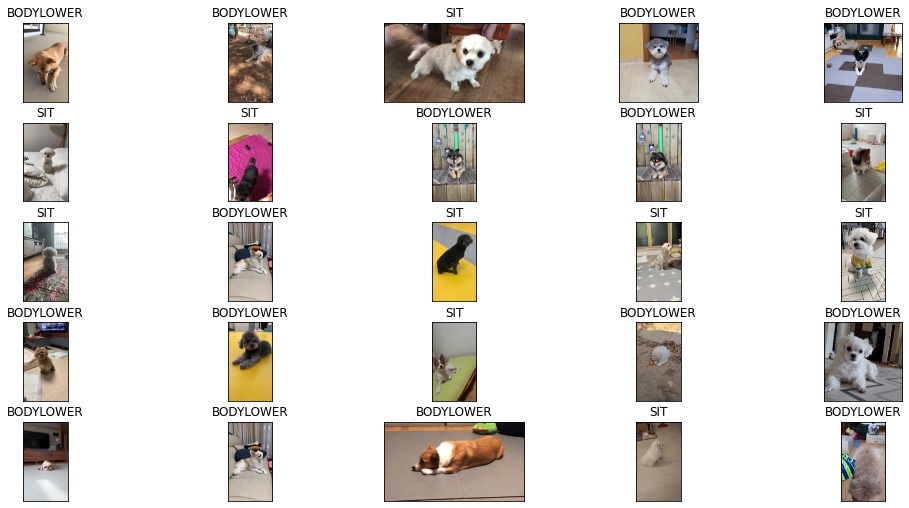

In [4]:
# 데이터 확인
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

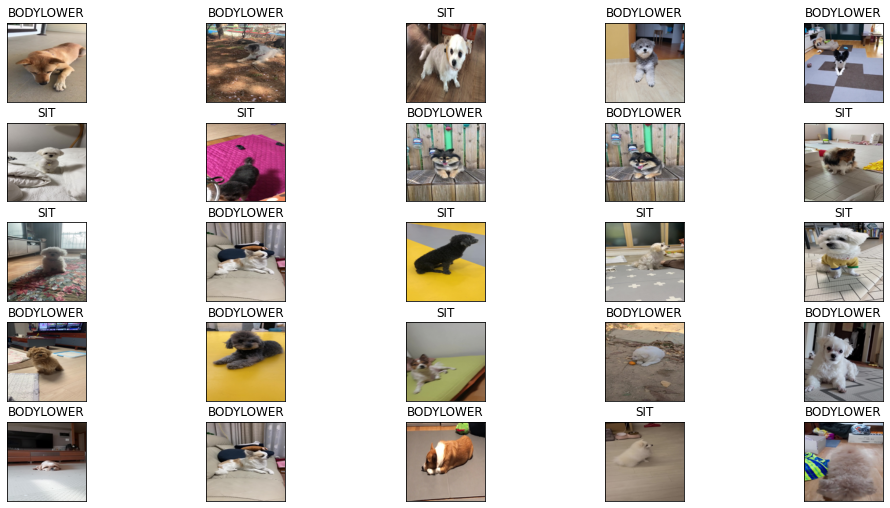

In [5]:
# 변형된 이미지 확인
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(df.Image[i])
    ax.set_title(df.Label[i], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

# 3.데이터 분류

In [6]:
# train, test set으로 split(8대 2)

train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((3792, 3), (949, 3))

In [7]:
# train_df를 8대 2로 split(train과 valid로)

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=0)
train_df.shape, valid_df.shape

((3033, 3), (759, 3))

In [21]:
#이미지 증강

# ImageDataGenerator 적용 과정(이미지 증강 과정)

# 이미지 크기 조정
def resize_image(filepath, target_size=(128, 128)):
    img = Image.open(filepath)
    img = img.resize(target_size)
    return np.array(img)


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30, # 회전제한 각도 30도
                                   zoom_range=0.15, # 확대 축소 15%
                                   width_shift_range=0.2, # 좌우이동 20%
                                   height_shift_range=0.2, # 상하이동 20%
                                   shear_range=0.15, # 반시계방햐의 각도
                                   horizontal_flip=True, # 좌우 반전 True
                                   fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(128, 128),
                                                    batch_size=75,
                                                    class_mode='categorical'
                                                    )

validation_generator = valid_datagen.flow_from_dataframe(valid_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(128, 128),
                                                     batch_size=75,
                                                     class_mode='categorical'
                                                     )

Found 3033 validated image filenames belonging to 2 classes.
Found 759 validated image filenames belonging to 2 classes.


In [22]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (75, 128, 128, 3)
배치 레이블 크기: (75, 2)


In [23]:
data_batch

array([[[[0.6899226 , 0.66114277, 0.63689405],
         [0.7125686 , 0.6823793 , 0.660219  ],
         [0.667428  , 0.6344504 , 0.60071594],
         ...,
         [0.72793627, 0.72009313, 0.7240147 ],
         [0.68416816, 0.676325  , 0.6802466 ],
         [0.6404002 , 0.63255703, 0.6364786 ]],

        [[0.69729054, 0.6629315 , 0.6311085 ],
         [0.7329747 , 0.6947001 , 0.6711707 ],
         [0.69948244, 0.65391314, 0.63038373],
         ...,
         [0.61370635, 0.6058632 , 0.6097848 ],
         [0.6       , 0.5921569 , 0.59607846],
         [0.6       , 0.5921569 , 0.59607846]],

        [[0.6966159 , 0.66132176, 0.63355005],
         [0.6802058 , 0.6355323 , 0.6104261 ],
         [0.6739944 , 0.6320988 , 0.6062982 ],
         ...,
         [0.6       , 0.5921569 , 0.59607846],
         [0.5990482 , 0.59120506, 0.5951266 ],
         [0.58567464, 0.5778315 , 0.5817531 ]],

        ...,

        [[0.36021566, 0.3445294 , 0.34845096],
         [0.3699419 , 0.35425562, 0.35817719]

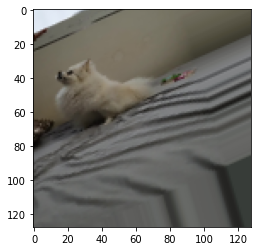

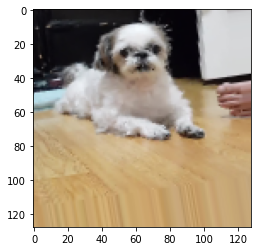

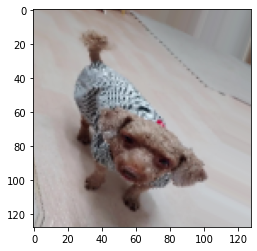

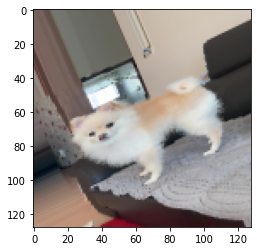

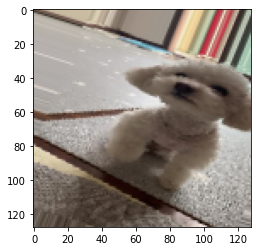

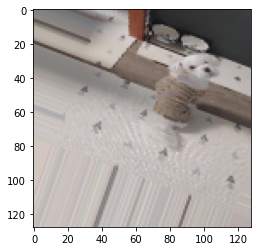

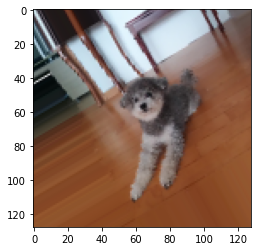

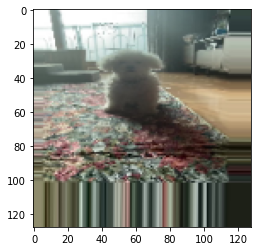

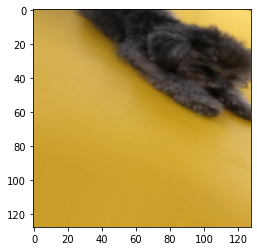

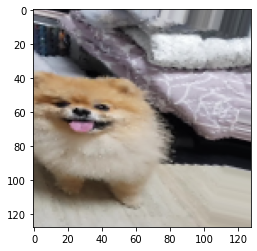

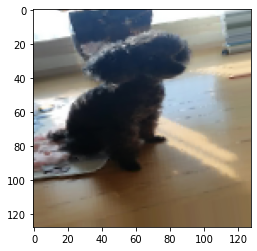

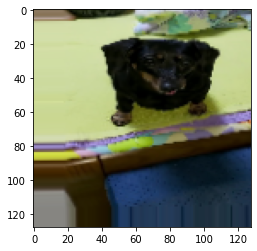

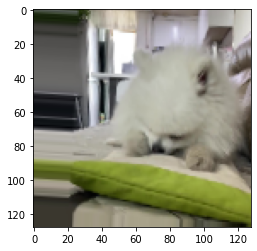

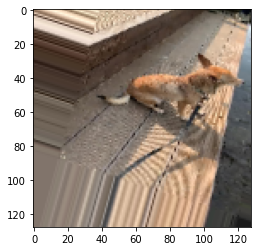

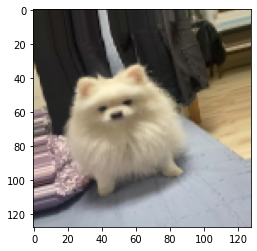

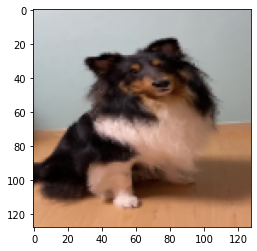

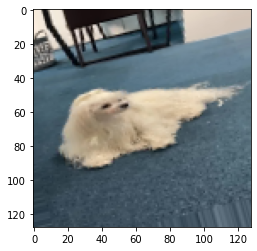

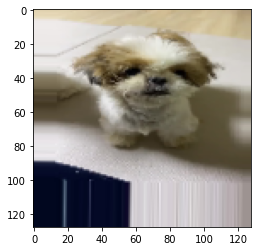

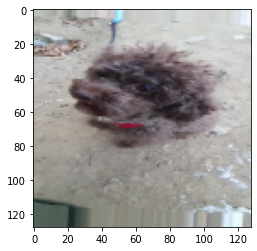

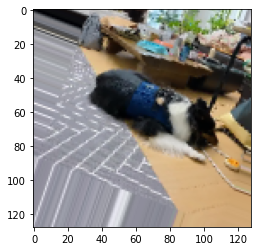

In [24]:
# 변형된 이미지 확인
# 이미지 출력할 개수
num_images_to_display = 20

# train_generator에서 이미지와 레이블을 가져오기
for data_batch, labels_batch in train_generator:
    for i in range(num_images_to_display):
        # data_batch에서 이미지 선택
        selected_image = data_batch[i]

        # 이미지를 출력
        plt.figure()
        plt.imshow(selected_image)
        plt.show()

    break  # 첫 번째 배치만 처리하고 종료

# 4. 모델링

In [12]:
# Convolutional Layer를 쌓아서 CNN 모델을 제작한다.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [25]:
%%time

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator,
                   steps_per_epoch=train_df.shape[0]//75,
                   epochs=15,
                   validation_data=validation_generator,
                   validation_steps=test_df.shape[0]//75,
                   verbose=2,
                    callbacks=[early_stopping])  # verbose 매개변수를 통해 에포크마다 상세 정보 출력 가능


Epoch 1/15
40/40 - 32s - loss: 0.6733 - accuracy: 0.6001 - val_loss: 0.6787 - val_accuracy: 0.5863 - 32s/epoch - 793ms/step
Epoch 2/15
40/40 - 26s - loss: 0.6740 - accuracy: 0.5984 - 26s/epoch - 653ms/step
Epoch 3/15
40/40 - 26s - loss: 0.6748 - accuracy: 0.5980 - 26s/epoch - 649ms/step
Epoch 4/15
40/40 - 26s - loss: 0.6741 - accuracy: 0.5977 - 26s/epoch - 643ms/step
Epoch 5/15
40/40 - 26s - loss: 0.6747 - accuracy: 0.5963 - 26s/epoch - 656ms/step
Epoch 6/15
40/40 - 27s - loss: 0.6738 - accuracy: 0.5984 - 27s/epoch - 674ms/step
Epoch 7/15
40/40 - 27s - loss: 0.6750 - accuracy: 0.5970 - 27s/epoch - 670ms/step
Epoch 8/15
40/40 - 27s - loss: 0.6739 - accuracy: 0.5980 - 27s/epoch - 669ms/step
Epoch 9/15
40/40 - 26s - loss: 0.6740 - accuracy: 0.5980 - 26s/epoch - 649ms/step
Epoch 10/15
40/40 - 26s - loss: 0.6743 - accuracy: 0.5970 - 26s/epoch - 651ms/step
Epoch 11/15
40/40 - 26s - loss: 0.6739 - accuracy: 0.5980 - 26s/epoch - 649ms/step
Epoch 12/15
40/40 - 26s - loss: 0.6750 - accuracy: 0.5

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

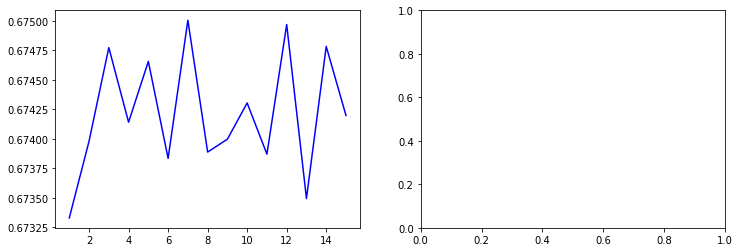

In [26]:
# 손실함수, 정확도 그래프 그리기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 15)

In [27]:
# Test 데이터셋으로 성능 확인하기

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(128, 128),
                                                  batch_size=75)
                                                  
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Found 949 validated image filenames belonging to 2 classes.
13/13 [==============================] - 7s 520ms/step - loss: 0.6827 - accuracy: 0.5722
Loss = 0.68269
Accuracy = 0.57218


In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
print(len(history.history['loss']))
print(len(history.history['accuracy']))
print(len(history.history['val_loss']))
print(len(history.history['val_accuracy']))


15
15
1
1


In [30]:
test_df.shape[0]

949

In [31]:
train_df.shape[0]

3033

In [32]:
model.save('cnn_test.h5')